In [35]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import h5py
import pandas as pd
#Pre-run code
import os
import sys
import gc
os.listdir('/mnt/c/Users/jdpul/OneDrive/Desktop/Galacticus-dust-modelling-main/dust_model')
sys.path.append('/mnt/c/Users/jdpul/OneDrive/Desktop/Galacticus-dust-modelling-main')
sys.path.append('/mnt/c/Users/jdpul/OneDrive/Desktop/Galacticus-dust-modelling-main/dust_model')
import birth_clouds1

In [36]:
import h5py
import numpy as np

#Loads filename for a specific simulation done by Galacticus.
#path_nodeData=Loads the datasets containing galaxies' astrophysical properties
#path_weight=Loads the mergerTreeWeights for UVLF or SMF construction by using binning method discussed in Section 3.4 (Galacticus_usage.pdf)
def UVLFs(filename, path_nodeData, path_weight, bins=50, MC_attenuation_boolean=False):
    # Converts Luminosity into Absolute Magnitude (UV_Magnitude). It also constrains any 0 Luminosity values to low luminosity values
    def M(values):
        values = np.where(values == 0, 0.99999, values)
        return -2.5 * np.log10(values)
    #Constrains galaxies that contain the corresponding metallicities with zero abundance gas metal and mass gas to low metallicities.
    def fix(name): 
        for i in range(len(name)):
            if np.isnan(name[i]) or name[i] == np.inf or name[i] < 1e-8:
                name[i] = 1e-8
        return name

    # Loads hdf5 files and stores necessary datasets such as:
    #Disk/Spheroid Stellar Luminosities, diskAbundancesGasMetal, DiskMassGas from the path_nodeData

    
    with h5py.File(filename, 'r') as f:
        # Extract datasets
        weights = np.array(f[f'{path_weight}/mergerTreeWeight'])
        disk=np.array(f[f'{path_nodeData}/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000'])
        spheroid=np.array(f[f'{path_nodeData}/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000'])
        
        #If user decides to compute the attenuation by Molecular clouds (i.e. Boolean=True) then it will load the necessary datasets
        #recent=Stellar Luminosities younger than 10Myr using the recent post-processor.
        #birth=retains starlight from birth clouds at different t_escapes provided by the simulation parameters.
        #Metallicities=defined by diskAbundanceGasMetals/diskMassGas
        if MC_attenuation_boolean:
            spheroid_recent = np.array(f[f'{path_nodeData}/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:recent'])
            disk_recent = np.array(f[f'{path_nodeData}/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:recent'])
            spheroid_birth = np.array(f[f'{path_nodeData}/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:birth'])
            disk_birth = np.array(f[f'{path_nodeData}/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:birth'])
            Z=np.array(f[f'{path_nodeData}/diskAbundancesGasMetals'])/np.array(f[f'{path_nodeData}/diskMassGas'])
            metallicities = fix(Z)

        #Computes the attenuation by clouds using the birth_clouds1 module.
            #Disk

            def disk_clouds_attenuation(metallicities, disk_birth, disk, wavelength):
                Ad_cloud = np.empty_like(metallicities, dtype=float)
                for i in range(len(metallicities)):
                    clouds = birth_clouds1.birth_clouds(Zcloud=metallicities[i], Birth=disk_birth[i], Default=disk[i],) #Used to calculate mean_eta (L_birth/L_default)
                    Ad_cloud[i] = clouds.attenuation(wavelength)
                    Ad_cloud = np.nan_to_num(Ad_cloud, nan=1.0) #Nan attenuations are primarily due to very low metallicities
                return Ad_cloud
                
             #Spheroid
            def spheroid_clouds_attenuation(metallicities, spheroid_birth, spheroid, wavelength):
                As_cloud = np.empty_like(metallicities, dtype=float)
                for i in range(len(metallicities)):
                    clouds = birth_clouds1.birth_clouds(Zcloud=metallicities[i], Birth=spheroid_birth[i], Default=spheroid[i],)
                    As_cloud[i] = clouds.attenuation(wavelength)
                    As_cloud = np.nan_to_num(As_cloud, nan=1.0)
                return As_cloud
                
            Ad=disk_clouds_attenuation(metallicities, disk_birth, disk, 3000) #Computes the individual attenuation coefficients for galaxy disk
            As=spheroid_clouds_attenuation(metallicities, spheroid_birth, spheroid, 3000) #Computes the individual attenuation coeff. for galaxy sph.

            disk_attenuated=disk*Ad #<A_MC>L_unatt
            spheroid_attenuated=spheroid*As 
            stellar_luminosity_attenuated = spheroid_attenuated+disk_attenuated #Add the attenuated luminosities from disk and spheroid
            luminosity_fixed_attenuated=M(stellar_luminosity_attenuated) #Change Luminosities to UV_M
            #Section 3.4 Galacticus_Usage.pdf
            counts, bin_edges = np.histogram(luminosity_fixed_attenuated, bins=bins, weights=weights) #Bin mergerTreeWeights per luminosity interval
            bin_width = np.diff(bin_edges) #figure out the width of the binning
            UVLF= counts / bin_width #normalize our "histogram" when constructing the UVLF. In this case, it is attenuated.
            M_UV= (bin_edges[:-1]+bin_edges[1:])/2 #bin centers to plot
            
        else:
            # Combine spheroid and disk mass
            stellar_luminosity= spheroid + disk
            # Apply M inside the function to remove low-mass haloes
            luminosity_fixed = M(stellar_luminosity)

            # Integrates UVLF as an histogram (mergerTreeWeights assign a weight for each halo merger tree)
            counts, bin_edges = np.histogram(luminosity_fixed, bins=bins, weights=weights)
            bin_width = np.diff(bin_edges) #Each bin of luminosity interval needs to be assigned 
            UVLF = counts / bin_width
            M_UV = (bin_edges[:-1] + bin_edges[1:]) / 2           


            

    return np.log10(UVLF), M_UV

In [37]:
UVLF1, M_UV1=UVLFs('LuminosityFuna0p5y.hdf5', 'Outputs/Output1/nodeData', 'Outputs/Output1')
UVLF2, M_UV2=UVLFs('LuminosityFuna0p5mc.hdf5', 'Outputs/Output1/nodeData', 'Outputs/Output1', MC_attenuation_boolean=True)
UVLF3, M_UV3=UVLFs('LuminosityFuna0p5mc1.hdf5', 'Outputs/Output1/nodeData', 'Outputs/Output1', MC_attenuation_boolean=True)

/tmp/ipykernel_36479/2869531100.py:89: RuntimeWarning: divide by zero encountered in log10
  return np.log10(UVLF), M_UV
/tmp/ipykernel_36479/2869531100.py:38: RuntimeWarning: invalid value encountered in divide
  Z=np.array(f[f'{path_nodeData}/diskAbundancesGasMetals'])/np.array(f[f'{path_nodeData}/diskMassGas'])
/tmp/ipykernel_36479/2869531100.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ad_cloud[i] = clouds.attenuation(wavelength)
/mnt/c/Users/jdpul/OneDrive/Desktop/Galacticus-dust-modelling-main/dust_model/birth_clouds1.py:59: RuntimeWarning: invalid value encountered in scalar divide
  return self.Birth/self.Default
/tmp/ipykernel_36479/2869531100.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element f

In [38]:
A05v4['Outputs/Output1/nodeData'].keys()

<KeysViewHDF5 ['basicMass', 'basicTimeLastIsolated', 'blackHoleMass', 'blackHoleSpin', 'darkMatterProfileScale', 'diskAbundancesGasMetals', 'diskAbundancesStellarMetals', 'diskAngularMomentum', 'diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000', 'diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:birth', 'diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:recent', 'diskMassGas', 'diskMassStellar', 'diskRadius', 'diskVelocity', 'hotHaloAbundancesMetals', 'hotHaloAngularMomentum', 'hotHaloMass', 'hotHaloOuterRadius', 'hotHaloOutflowedAbundancesMetals', 'hotHaloOutflowedAngularMomentum', 'hotHaloOutflowedMass', 'hotHaloUnaccretedAbundancesMetals', 'hotHaloUnaccretedMass', 'mergerTreeWeight', 'nodeSubsamplingWeight', 'redshift', 'satelliteBoundMass', 'spheroidAbundancesGasMetals', 'spheroidAbundancesStellarMetals', 'spheroidAngularMomentum', 'spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000', 'spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8

Text(0, 0.5, 'Log($\\Phi$, $[{\\rm Mpc}^{-3}M_{UV}^{-1}]$)')

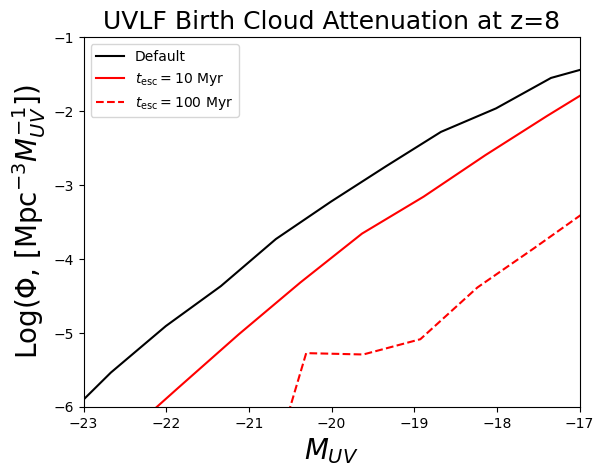

In [39]:
plt.title("UVLF Birth Cloud Attenuation at z=8", fontsize=18)
plt.plot(M_UV1, UVLF1, label=r'Default', color='black')
plt.plot(M_UV2, UVLF2, label=r'$t_\mathrm{{esc}} = 10$ Myr', color='red')
plt.plot(M_UV3, UVLF3, label=r'$t_\mathrm{{esc}} = 100$ Myr', color='red', ls='--')
plt.legend()
plt.ylim([-6, -1])
plt.xlim([-23, -17])
plt.xlabel(r'$M_{UV}$', fontsize=20)
plt.ylabel(r"Log($\Phi$, $[{\rm Mpc}^{-3}M_{UV}^{-1}]$)", fontsize=20)